# Paper Related Information

**Paper**: U-GAT-IT: Unsupervised Generative Attentional Networks with Adaptive Layer-Instance Normalization for Image-to-Image Translation,  https://arxiv.org/abs/1907.10830


**Authors**: Junho Kim, Minjae Kim, Hyeonwoo Kang, Kwanghee Lee.

**Code Authors**: Onur Can Üner: onur.uner@metu.edu.tr, Sinan Gençoğlu: sinan.gencoglu@metu.edu.tr

# Paper Summary 

## Abstract & Introduction

U-gat-it proposes a novel method for unsupervised image-to-image translation, which incorporates a new attention module and a new learnable normalization function in an end-to-end manner. The attention module guides our model to focus on more important regions distinguishing between source and target domains based on the attention map obtained by the auxiliary classifier. Unlike previous attention-based method which cannot handle the geometric changes between domains, our model can translate both images requiring holistic changes and images requiring large shape changes. Moreover, our new AdaLIN (Adaptive Layer-Instance Normalization) function helps our attention-guided model to flexibly control the amount of change in shape and texture by learned parameters depending on datasets.

<h5><center>Some samples shown below. (a) Source images (b,c,d) Attentions maps (e) Ugatit results </center></h5>

<div><img src="images/sample.png" width="550"/></div>

## Method

### Model flow of U-GAT-IT



<div><img src="images/model.png" width="600"/></div>

Main goal of the model is to train a function that maps images from a source domain to target domain using only unpaired samples drawn from each domain. The model consist of two generators (one maps images source to target other maps images target to source, generators are same for each task) and two discriminators (one for source other for target domain).

Model generator consist of an encoder, decoder and an auxiliary classifier which defines probability that input comes from source domain. Basically, auxiliary classifier is trained to learn the weight of the features maps for the source domain by using global and max pooling operations.

Generators and discriminators consist of Resnet Blocks. In addition to that, blocks are using AdaLIN normalization whose parameters, γ and β are dynamically computed by a fully connected layer from the attention maps instead of using classical instance normalization. μI , μL and σI , σL are channel-wise, layer-wise mean and standard deviation respectively, γ and β are parameters generated by the fully connected layer, τ is the learning rate and ∆ρ indicates the parameter update vector determined by the optimizer.

<div><img src="images/adalin.png" width="400"/></div>

* In this model authors have applied the AdaLIN only to the decoder of the generator. The role of the residual blocks in the decoder is to embed features, and the role of the up-sampling convolution blocks in the decoder is to generate target domain images from the embedded features. 

As far as we understand from the method, AdaLIN helps to keep the content structure of the original domain because it consider global statistics over all features maps and dynamically updated according to training batches over time. 

### Objective

The full objective of the model comprises four loss functions.

1. Adversarial loss:
    * An adversarial loss is employed to match the distribution of the translated images to the target image distribution:
    
    <div><img src="images/adverserial.png" width="700"/></div>
    
2. Cycle loss:
    * Given an image x ∈ source domain, after the sequential translations of x from source to target and from target to source, the image should be successfully translated back to the original domain:
    
    <div><img src="images/cycle.png" width="450"/></div>
    
3. Identity loss:
    * To ensure that the color distributions of input image and output image are similar, they apply an identity consistency constraint to the generator. Given an image x ∈ target, after the translation of x using source to domain generator, the image should not change.
    
    <div><img src="images/identity.png" width="400"/></div>

4. CAM loss:
    * Given an image x ∈ {Xs,Xt}. Networks get to know where they need to improve or what makes the most difference between two domains in the current state:
    
    <div><img src="images/cam.png" width="400"/></div>

5. Full objective:
    * Finally, they jointly train the encoders, decoders, discriminators, and auxiliary classifiers to optimize the final objective:
    
    <div><img src="images/full.png" width="700"/></div>
    

## Model Architecture

The network architectures of U-GAT-IT as follows. The encoder of the generator is composed of two convolution layers with the stride size of two for down-sampling and four residual blocks. The decoder of the generator consists of four residual blocks and two up-sampling convolution layers with the stride size of one. They use use the instance normalization for the encoder and AdaLIN for the decoder, respectively.

They employ two different scales of PatchGAN (Isola et al. (2017)) for the discriminator network, which classifies whether local and global image patches are real or fake. For the activation function, they use ReLU in the generator and leaky-ReLU with a slope of 0.2 in the discriminator.

<h5><center>The detail of generator architecture. </center></h5>
<div><img src="images/generator.png" width="700"/></div>

<h5><center>The detail of local discriminator. </center></h5>
<div><img src="images/localD.png" width="700"/></div>

<h5><center>The detail of global discriminator. </center></h5>
<div><img src="images/globalD.png" width="700"/></div>

## Training

All models are trained using Adam optimizer with β1=0.5 and β2=0.999. For data augmentation, flipped the images horizontally with a probability of 0.5, resized them to 286 x 286, and random cropped them to 256 x 256. The batch size is set to one for all experiments. We trained all models with a fixed learning rate of 0.0002 and reduced it by 0.5 in the 50th and 100th epochs.

## Dataset

We used selfie2anime dataset which consist of 3400 images for training and 100 images for testing purposes. All images are resized to 256x256 for training. Some samples are shown below.

<h5><center>Selfie to anime Dataset </center></h5>
<div><img src="images/data.jpg" width="550"/></div>

* We implement general config json file for any configuration over networks and training details.

## Models

Our overall architecture can be classified as follows:

1. Generator
2. Discriminator
3. Spesific layers for generators and discriminators.

In [ ]:
## Imports

import torch
import torch.nn as nn

## Generator(s)

class Generator(nn.Module):
    def __init__(self, bias=False, reflection=False):
        super().__init__()
        # ----------- Encoder -----------
        # (Table-4: Part -> Encoder Down-sampling)
        # (h, w, 3) → (h, w, 64)
        # (h, w, 64) → ( h/2 , w/2 , 128)
        # (h/2 , w/2 , 128) → (h/4 , w/4 , 256)
        self.encoder_down = nn.Sequential(
            ConvINReLU(3, 64, kernel_size=7, padding=3, stride=1, bias=bias, reflection=reflection),
            ConvINReLU(64, 128, kernel_size=3, padding=1, stride=2, bias=bias, reflection=reflection),
            ConvINReLU(128, 256, kernel_size=3, padding=1, stride=2, bias=bias, reflection=reflection)
        )

        # (Table-4: Part -> Encoder Bottleneck)
        # (h/4 , w/4 , 256) → (h/4 , w/4 , 256) * 4 times
        self.encoder_bottleneck_1 = ResINBlock(256, bias=bias, reflection=reflection)
        self.encoder_bottleneck_2 = ResINBlock(256, bias=bias, reflection=reflection)
        self.encoder_bottleneck_3 = ResINBlock(256, bias=bias, reflection=reflection)
        self.encoder_bottleneck_4 = ResINBlock(256, bias=bias, reflection=reflection)

        # (Table-4: Part -> CAM of Generator)
        self.cam = CAM(256)

        # (Table-4: Part -> Gamma, Beta)
        self.gamma_mlp = nn.Sequential(
            nn.Linear(256, 256, bias=False), nn.ReLU(),     # (h/4 , w/4 , 256) → (1, 1, 256)
            nn.Linear(256, 256, bias=False), nn.ReLU(),     # (1, 1, 256) → (1, 1, 256)
            nn.Linear(256, 256, bias=False)                 # (1, 1, 256) → (1, 1, 256)
        )

        self.beta_mlp = nn.Sequential(
            nn.Linear(256, 256, bias=False), nn.ReLU(),     # (h/4 , w/4 , 256) → (1, 1, 256)
            nn.Linear(256, 256, bias=False), nn.ReLU(),     # (1, 1, 256) → (1, 1, 256)
            nn.Linear(256, 256, bias=False)                 # (1, 1, 256) → (1, 1, 256)
        )

        # ----------- Decoder -----------
        # (Table-4: Part -> Decoder Bottleneck)
        # (h/4 , w/4 , 256) → (h/4 , w/4 , 256) * 4 times
        self.decoder_bottleneck_1 = ResAdaILNBlock(256, bias=bias, reflection=reflection)
        self.decoder_bottleneck_2 = ResAdaILNBlock(256, bias=bias, reflection=reflection)
        self.decoder_bottleneck_3 = ResAdaILNBlock(256, bias=bias, reflection=reflection)
        self.decoder_bottleneck_4 = ResAdaILNBlock(256, bias=bias, reflection=reflection)

        # (Table-4: Part -> Decoder Up-sampling)
        # (h/4 , w/4 , 256) → (h/2 , w/2 , 128)
        # (h/2 , w/2 , 128) → (h , w , 64)
        # (h, w, 64) → (h, w, 3)
        self.decoder_up = nn.Sequential(
            UpConvILNReLU(256, 128, 3, 1, scale_factor=2, bias=bias, reflection=reflection),
            UpConvILNReLU(128,  64, 3, 1, scale_factor=2, bias=bias, reflection=reflection),
            Conv2D(64, 3, kernel_size=7, padding=3, stride=1, bias=bias, reflection=reflection),
            nn.Tanh()
        )

    def forward(self, x):
        B = x.shape[0]
        x = self.encoder_down(x)
        x = self.encoder_bottleneck_1(x)
        x = self.encoder_bottleneck_2(x)
        x = self.encoder_bottleneck_3(x)
        x = self.encoder_bottleneck_4(x)
        x, cam_logits = self.cam(x)

        x_avg = torch.nn.functional.adaptive_avg_pool2d(x, output_size=1).view(B, -1)
        gamma = self.gamma_mlp(x_avg)
        beta = self.beta_mlp(x_avg)

        x = self.decoder_bottleneck_1(x, gamma, beta)
        x = self.decoder_bottleneck_2(x, gamma, beta)
        x = self.decoder_bottleneck_3(x, gamma, beta)
        x = self.decoder_bottleneck_4(x, gamma, beta)

        out = self.decoder_up(x)
        return out, cam_logits
    

## Discriminators

class LocalDiscriminator(nn.Module):
    def __init__(self, reflection=False):
        super().__init__()
        # ----------- Local Discriminator -----------
        # ----------- Encoder -----------
        # (Table-5: Part -> Encoder Down-sampling)
        # (h, w, 3) → (h/2, w/2, 64)
        # (h/2, w/2, 64) → (h/4, w/4, 128)
        # (h/4, w/4, 128) → (h/8, w/8, 256)
        # (h/8, w/8, 256) → (h/8 , w/8 , 512)
        self.encoder_downsampling = nn.Sequential(
            ConvSNLeakyReLU(3,    64, kernel_size=4, padding=1, stride=2, bias=True, reflection=reflection),
            ConvSNLeakyReLU(64,  128, kernel_size=4, padding=1, stride=2, bias=True, reflection=reflection),
            ConvSNLeakyReLU(128, 256, kernel_size=4, padding=1, stride=2, bias=True, reflection=reflection),
            ConvSNLeakyReLU(256, 512, kernel_size=4, padding=1, stride=1, bias=True, reflection=reflection)
        )

        # (Table-5: Part -> CAM of Discriminator)
        self.cam = CAM(512, act=nn.LeakyReLU(0.2), spectral_norm=True)

        # (Table-5: Part -> Classifier)
        # (h/8, w/8, 512) → (h/8, w/8, 1)
        self.classifier = ConvSN2D(512, 1, kernel_size=4, padding=1, stride=1, bias=False, reflection=reflection)

    def forward(self, x):
        x = self.encoder_downsampling(x)
        x, cam_logits = self.cam(x)
        out = self.classifier(x)
        return out, cam_logits


class GlobalDiscriminator(nn.Module):
    def __init__(self, reflection=False):
        super().__init__()
        # ----------- Local Discriminator -----------
        # ----------- Encoder -----------
        # (Table-6: Part -> Encoder Down-sampling)
        # (h, w, 3) → (h/2, w/2, 64)
        # (h/2, w/2, 64) → (h/4, w/4, 128)
        # (h/4, w/4, 128) → (h/8, w/8, 256)
        # (h/8, w/8, 256) → (h/16 , w/16 , 512)
        # (h/16, w/16, 256) → (h/32 , w/32 , 1024)
        # (h/32 , w/32 , 1024) → (h/32 , w/32 , 2048)
        self.encoder_downsampling = nn.Sequential(
            ConvSNLeakyReLU(3,    64, kernel_size=4, padding=1, stride=2, bias=True, reflection=reflection),
            ConvSNLeakyReLU(64,  128, kernel_size=4, padding=1, stride=2, bias=True, reflection=reflection),
            ConvSNLeakyReLU(128, 256, kernel_size=4, padding=1, stride=2, bias=True, reflection=reflection),
            ConvSNLeakyReLU(256, 512, kernel_size=4, padding=1, stride=2, bias=True, reflection=reflection),
            ConvSNLeakyReLU(512, 1024, kernel_size=4, padding=1, stride=2, bias=True, reflection=reflection),
            ConvSNLeakyReLU(1024, 2048, kernel_size=4, padding=1, stride=1, bias=True, reflection=reflection),
        )

        # (Table-6: Part -> CAM of Discriminator)
        self.cam = CAM(2048, act=nn.LeakyReLU(0.2), spectral_norm=True)

        # (Table-6: Part -> Classifier)
        # (h/8, w/8, 512) → (h/8, w/8, 1)
        self.classifier = ConvSN2D(2048, 1, kernel_size=4, padding=1, stride=1, bias=False, reflection=reflection)

    def forward(self, x):
        x = self.encoder_downsampling(x)
        x, cam_logits = self.cam(x)
        out = self.classifier(x)
        return out, cam_logits

    
## Specific Layers

class Conv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, stride, bias=False, reflection=False):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        if reflection:
            self.conv = nn.Sequential(
                nn.ReflectionPad2d(padding),
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, bias=bias))

    def forward(self, x):
        return self.conv(x)


class ConvINReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, stride, bias=False, reflection=False):
        super().__init__()
        self.conv = Conv2D(in_channels, out_channels, kernel_size, padding, stride, bias, reflection)
        self.norm = nn.InstanceNorm2d(out_channels)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        return self.act(x)


class ResINBlock(nn.Module):
    def __init__(self, in_channels, bias=False, reflection=False):
        super().__init__()

        self.block = nn.Sequential(
            ConvINReLU(in_channels, in_channels, 3, 1, 1, bias, reflection),
            Conv2D(in_channels, in_channels, 3, 1, 1, bias, reflection),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)


class CAM(nn.Module):
    def __init__(self, in_channels, act=nn.ReLU(), spectral_norm=False):
        super().__init__()
        self.mlp_gap = nn.Linear(in_channels, 1, bias=False)
        self.mlp_gmp = nn.Linear(in_channels, 1, bias=False)
        self.cam_conv = nn.Conv2d(in_channels*2, in_channels, kernel_size=1, stride=1, bias=True)
        self.cam_act = act

        if spectral_norm:
            self.mlp_gap = nn.utils.spectral_norm(self.mlp_gap)
            self.mlp_gmp = nn.utils.spectral_norm(self.mlp_gmp)

    def forward(self, x):
        B = x.shape[0]
        gap = torch.nn.functional.adaptive_avg_pool2d(x, 1).view(B, -1)     # BxC
        gap_logits = self.mlp_gap(gap)
        gap_weight = list(self.mlp_gap.parameters())[0].unsqueeze(2).unsqueeze(3)
        gap = x * gap_weight    # BxCxHxW

        gmp = torch.nn.functional.adaptive_max_pool2d(x, 1).view(B, -1)
        gmp_logits = self.mlp_gmp(gmp)
        gmp_weight = list(self.mlp_gmp.parameters())[0].unsqueeze(2).unsqueeze(3)
        gmp = x * gmp_weight

        cam_logits = torch.cat([gap_logits, gmp_logits], dim=1)
        x = torch.cat([gap, gmp], dim=1)
        x = self.cam_act(self.cam_conv(x))
        return x, cam_logits


class AdaILN(nn.Module):
    def __init__(self, num_features, eps=1e-5):
        super().__init__()

        self.num_features = num_features
        self.eps = eps
        # The value of ρ is initialized to 1 in the residual blocks of the decoder
        self.rho = nn.Parameter(torch.empty(1, num_features, 1, 1), requires_grad=True)
        self.rho.data.fill_(1.0)

    def forward(self, x, gamma, beta):
        B, C, _, _ = x.shape
        scale = gamma.unsqueeze(2).unsqueeze(3)
        bias = beta.unsqueeze(2).unsqueeze(3)

        in_mean = torch.mean(x.view(B, C, -1), dim=2).unsqueeze(2).unsqueeze(3)
        in_var = torch.var(x.view(B, C, -1), dim=2).unsqueeze(2).unsqueeze(3)
        a_in = (x - in_mean) / torch.sqrt((in_var + self.eps))

        ln_mean = torch.mean(x.view(B, -1), 1).unsqueeze(1).unsqueeze(2).unsqueeze(3)
        ln_var = torch.var(x.view(B, -1), 1).unsqueeze(1).unsqueeze(2).unsqueeze(3)
        a_ln = (x - ln_mean) / torch.sqrt((ln_var + self.eps))

        rho = self.rho.expand(B, -1, -1, -1)
        return scale * (rho * a_in + (1. - rho) * a_ln) + bias


class ILN(nn.Module):
    def __init__(self, num_features, eps=1e-5):
        super().__init__()

        self.num_features = num_features
        self.eps = eps
        # The value of ρ is initialized to 0 in the up-sampling blocks of the decoder
        self.rho = nn.Parameter(torch.empty(1, num_features, 1, 1), requires_grad=True)
        self.gamma = nn.Parameter(torch.empty(1, num_features, 1, 1), requires_grad=True)
        self.beta = nn.Parameter(torch.empty(1, num_features, 1, 1), requires_grad=True)
        self.rho.data.fill_(0.0)
        self.gamma.data.fill_(1.0)
        self.beta.data.fill_(0.0)

    def forward(self, x):
        B, C, _, _ = x.shape
        in_mean = torch.mean(x.view(B, C, -1), dim=2).unsqueeze(2).unsqueeze(3)
        in_var = torch.var(x.view(B, C, -1), dim=2).unsqueeze(2).unsqueeze(3)
        a_in = (x - in_mean) / torch.sqrt((in_var + self.eps))

        ln_mean = torch.mean(x.view(B, -1), 1).unsqueeze(1).unsqueeze(2).unsqueeze(3)
        ln_var = torch.var(x.view(B, -1), 1).unsqueeze(1).unsqueeze(2).unsqueeze(3)
        a_ln = (x - ln_mean) / torch.sqrt((ln_var + self.eps))

        rho = self.rho.expand(B, -1, -1, -1)
        scale = self.gamma.expand(B, -1, -1, -1)
        bias = self.gamma.expand(B, -1, -1, -1)
        return scale * (rho * a_in + (1. - rho) * a_ln) + bias


class ResAdaILNBlock(nn.Module):
    def __init__(self, in_channels, bias=False, reflection=False):
        super().__init__()
        self.conv1 = Conv2D(in_channels, in_channels, 3, 1, 1, bias=bias, reflection=reflection)
        self.norm1 = AdaILN(in_channels)

        self.conv2 = Conv2D(in_channels, in_channels, 3, 1, 1, bias=bias, reflection=reflection)
        self.norm2 = AdaILN(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x, gamma, beta):
        out = self.conv1(x)
        out = self.norm1(out, gamma, beta)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.norm2(out, gamma, beta)
        return x + out


class UpConvILNReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, scale_factor=2, bias=False, reflection=False):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode='nearest')
        self.conv = Conv2D(in_channels, out_channels, kernel_size, padding, stride=1, bias=bias, reflection=reflection)
        self.norm = ILN(out_channels)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.upsample(x)
        x = self.conv(x)
        x = self.norm(x)
        return self.act(x)


# ------------------------ Discriminator Specific Layers ------------------------
class ConvSN2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, stride, bias=False, reflection=False):
        super().__init__()
        if reflection:
            self.conv = nn.Sequential(
                nn.ReflectionPad2d(padding),
                nn.utils.spectral_norm(
                    nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, bias=bias)))
        else:
            self.conv = nn.utils.spectral_norm(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias))

    def forward(self, x):
        return self.conv(x)


class ConvSNLeakyReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, stride, bias=True, reflection=False):
        super().__init__()
        self.block = nn.Sequential(
            ConvSN2D(in_channels, out_channels, kernel_size, padding, stride, bias=bias, reflection=reflection),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.block(x)

* Other architecture details can be found on library folder.

## Training

In [1]:
import os
import sys
import json
import random
import argparse
import datetime
import numpy as np
from pathlib import Path
from easydict import EasyDict as edict

import torch
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader

from train import main
from lib.utils import Logger

## Hyperparameters and Configs

You can change everything you want using json file. The file consists of every architectural detail as well as hyperparameters.

In [ ]:
## All configs you can change using json file.

"""
{
    "name": "UGATIT_selfie2anime",
    "n_gpu": 1,

    "arch": {
        "type": "UGATIT",
        "args": {
            "adv_weight": 1,
            "cycle_weight": 10,
            "idt_weight": 10,
            "cam_weight": 1000,
            "reflection": true
        }
    },

    "datamanager": {
        "type": "ImageFoldersAB",
        "root": "./data",
        "dataset_dir": "selfie2anime",
        "height": 256,
        "width": 256,
        "norm_mean": null,
        "norm_std": null,
        "pin_memory": false,
        "batch_size_train": 1,
        "batch_size_test": 1,
        "workers": 16
    },

    "optimizer": {
        "generator": {
            "type": "adam",
            "args": {
                "lr": 0.0001,
                "betas": [0.5, 0.99],
                "weight_decay": 0.0001
            }
        },
        "discriminator": {
            "type": "adam",
            "args": {
                "lr": 0.0001,
                "betas": [0.5, 0.99],
                "weight_decay": 0.0001
            }
        }
    },

    "lr_scheduler": {
        "generator": {
            "type": "multi_step",
            "args": {
                "stepsize": [50, 100],
                "gamma": 0.5
            }
        },
        "discriminator": {
            "type": "multi_step",
            "args": {
                "stepsize": [50, 100],
                "gamma": 0.5
            }
        }
    },

    "trainer": {
        "type": "UGATITTrainer",
        "epochs": 100,
        "save_dir": "saved/",
        "save_period": 1,

        "monitor": "max",
        "early_stop": 200,
        "log_per_batch": 300,

        "val": true,
        "val_per_epochs": 1,

        "visualize_train_batch": true,
        "visualize_val_batch": true,
        "vis_count": 40
    },

    "deployment": {
        "best_model": ""
    }
}
"""

In [ ]:
# Config path
config_path = "./configs/selfie2anime.json"

# Resume training the checkpoint
resume_path = ""

# Setup seeds
torch.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(123)
random.seed(123)
cudnn.benchmark = True

config = json.load(open(config_path))
config = edict(config)

start_time = datetime.datetime.now().strftime('%m-%d_%H-%M')
save_dir = Path('.').resolve() / config.trainer.save_dir / config.name / start_time
log_dir = save_dir / 'logs'
log_dir.mkdir(parents=True, exist_ok=True)
sys.stdout = Logger(log_dir / 'train.txt')

main(config, resume_path, save_dir, log_dir)


Dataset: ImageFoldersAB
    # data: 3400



Dataset: ImageFoldersAB
    # data: 100


Detected GPUs: 1 Requested: 1


TRAIN [1] G: 528.257(1259.785) | D: 1.655(2.960) | LR_G 0.00010 | LR_D 0.00010 | B 0.45 D 0.00: 100%|██████████| 3400/3400 [25:42<00:00,  2.20it/s]  
EVAL [1] | G: 0.000(0.000) | D: 0.000(0.000): 100%|██████████| 100/100 [00:10<00:00,  9.88it/s]
TRAIN [2] G: 93.072(418.075) | D: 2.353(2.478) | LR_G 0.00010 | LR_D 0.00010 | B 0.45 D 0.00: 100%|██████████| 3400/3400 [25:44<00:00,  2.20it/s]  
EVAL [2] | G: 0.000(0.000) | D: 0.000(0.000): 100%|██████████| 100/100 [00:10<00:00,  9.88it/s]
TRAIN [3] G: 618.437(276.948) | D: 3.169(2.446) | LR_G 0.00010 | LR_D 0.00010 | B 0.45 D 0.00:  17%|█▋        | 588/3400 [04:27<22:05,  2.12it/s] 

**Loss Curves During Training**

<h5><center>Generator Training Loss During Training</center></h5>
<div><img src="images/train_lossG.jpeg" width="700"/></div>

<h5><center>Discriminator Training Loss During Training</center></h5>
<div><img src="images/train_lossD.jpeg" width="700"/></div>

**Important Note**

* The output of the above code cell are just to show that our training code is working. Because of this, we have stopped the training after 2 epochs. Each epoch takes about 30 minutes as shown above. We have actually trained our network 42 epochs. According to the article where they stated that they train their networks with 1,000,000 iterations, training with 40 epochs is not enough. In our case 1M iterations corresponds to ~300 epoch in our case. We will complete our training phase in the version 2.

* In order not to slow down the training phase, the intermediate results were saved in a separate file. You can see some of the intermediate results below.

<h5><center>Intermediate Results </center></h5>
<div><img src="images/intermediates.png" width="550"/></div>

## Testing

In [1]:
# import neccessary libraries
import json
import numpy as np
import matplotlib.pyplot as plt
from easydict import EasyDict as edict

import torch
import torchvision
from torchvision.utils import make_grid

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import lib.models as models
import lib.data as datasets
from lib.utils import code_backup, load_checkpoint

In [2]:
# Get configs
config = edict(json.load(open('configs/selfie2anime.json')))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load model
checkpoint = './saved/UGATIT_selfie2anime/05-30_00-05/checkpoints/checkpoint-epoch42.pth'
model = getattr(models, config.arch.type)(**config.arch.args)
checkpoint = load_checkpoint(checkpoint)
model.load_pretrained_weights(checkpoint['state_dict'])
del checkpoint
model.to(device)
model.eval()

Successfully loaded pretrained weights


UGATIT(
  (G_AB): Generator(
    (encoder_down): Sequential(
      (0): ConvINReLU(
        (conv): Conv2D(
          (conv): Sequential(
            (0): ReflectionPad2d((3, 3, 3, 3))
            (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), bias=False)
          )
        )
        (norm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (act): ReLU()
      )
      (1): ConvINReLU(
        (conv): Conv2D(
          (conv): Sequential(
            (0): ReflectionPad2d((1, 1, 1, 1))
            (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
          )
        )
        (norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (act): ReLU()
      )
      (2): ConvINReLU(
        (conv): Conv2D(
          (conv): Sequential(
            (0): ReflectionPad2d((1, 1, 1, 1))
            (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
          )
        )

In [4]:
# Generate validation(test) set

val_set = getattr(datasets, config.datamanager.type)(
        config.datamanager.root, config.datamanager.dataset_dir,
        width=config.datamanager.width,
        height=config.datamanager.height,
        mean=config.datamanager.norm_mean,
        std=config.datamanager.norm_std,
        mode="test")

## Qualitative & Quantitative Results

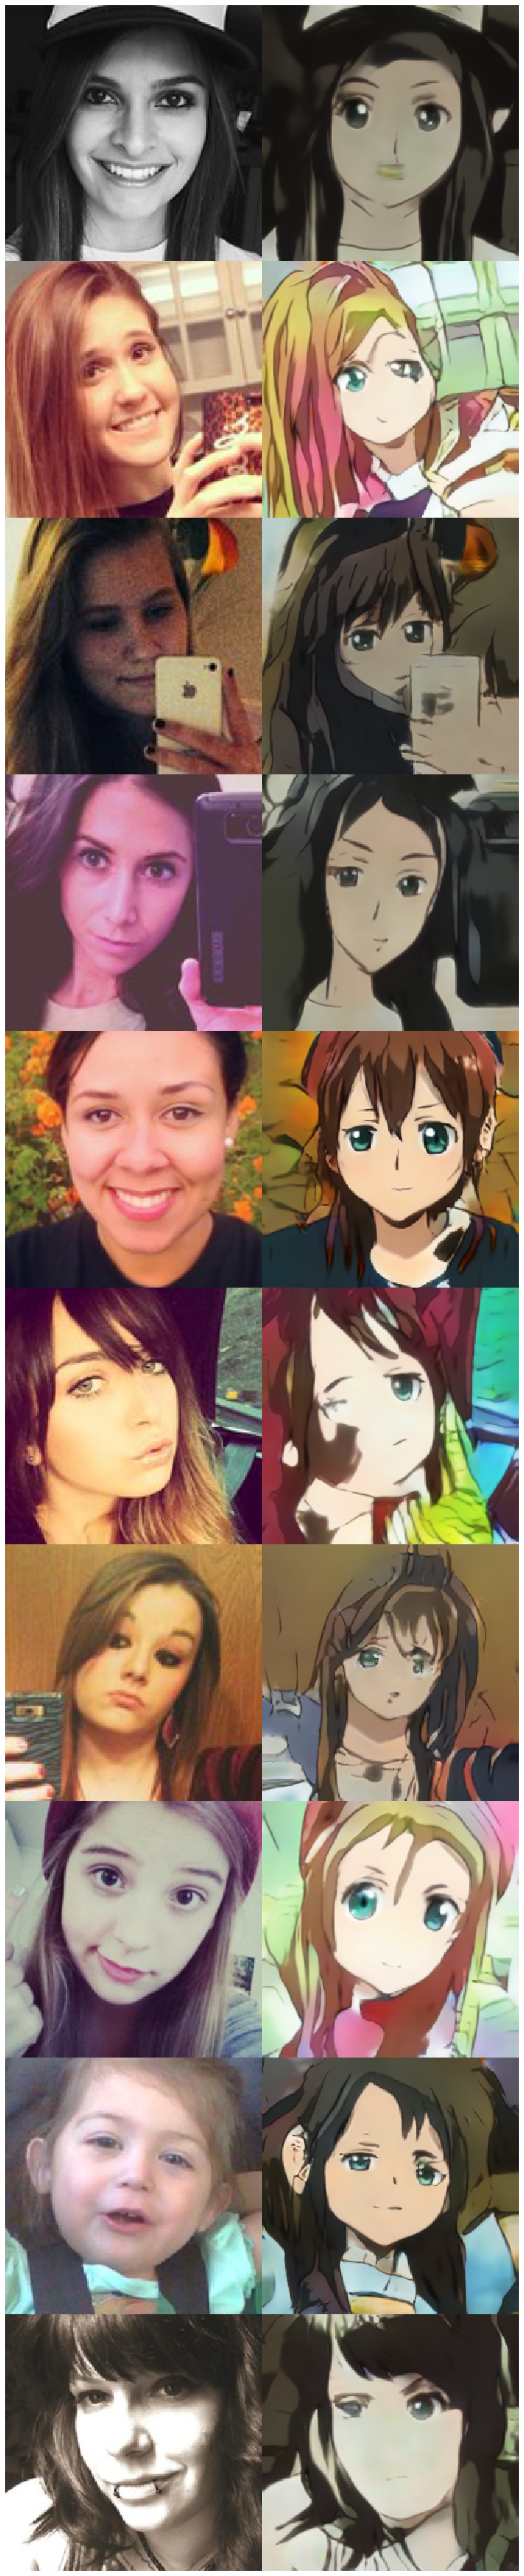

In [15]:
images = []
for i, data in enumerate(val_set):
    if i == 10:
        break
    real_A = data['A'].to(device).unsqueeze(0)
    real_B = data['B'].to(device).unsqueeze(0)

    _, fake_B = model.forward(real_A, real_B)
    
    real_A = val_set.denormalize(real_A, device=device)
    fake_B = val_set.denormalize(fake_B, device=device)

    images.append(torch.cat((real_A.cpu().detach(), fake_B.cpu().detach()), dim=-1))
    
images = torch.cat(images, dim=-2)
images = make_grid(images, padding=100).numpy()
plt.figure(figsize = (128, 64))
plt.axis('off')
plt.imshow(np.transpose(images, (1,2,0)), interpolation='nearest')

<h7><center>**U-GAT-IT official KID Scores** </center></h7>

<div><img src="images/metrics.png" width="400"/></div>

In [26]:
# Calculating KID Score for 100 test images. (Batch size=2)
!python ./lib/eval/kid.py --real data/real --fake data/fake 

100%|███████████████████████████████████████████| 50/50 [00:26<00:00,  1.88it/s]
data/fake
MMD: 100%|█████████████████████████| 100/100 [00:23<00:00,  4.19it/s, mean=0.21]
KID mean:20.97


* Class activation maps tell us that the generator is focusing on important features as we expected. When we translate source image to target, we expect the changing features to be mostly eyes, nose and mouth etc.

<h7><center>**Class activation maps** </center></h7>

<div><img src="images/cams.jpg" width="850"/></div>

### Difficulties encountered

* We had to use some padding techniques because the layers used in the architecture of the generator and discriminator networks and their outputs were not compatible in some parts.
* The details of the method used in the auxiliary classifier architecture were not much detailed, so we had to experiment and implement it a lot.
* We had a lot of difficulty in training because the image size and architecture were very large and we had limited computational capacity. Maybe it would be much more convenient to do similar experiments by reducing the image size.

### Additional Notes

* We have used different learning rate scheduler than the mentioned in the paper. The authors say they used a fixed learning rate of 0.0001 up to 500,000 iterations, and they decayed linearly up to 1,000,000 iterations. Instead of using linearly decaying learning rate after 500,000 iterations, we have reduced learning rate after 50 and 100 epochs by 0.5 times.
* The value of ρ is initialized with the value of 0.9 in the AdaILN blocks. This value is initialized to 1 in the article but converging was slower with ρ value as 1.